In [1]:
!pip install skompiler
!pip install astor
!pip install xgboost
!pip install catboost
!pip install lightgbm
!pip install researchpy

In [2]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from skompiler import skompile
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from lightgbm import LGBMRegressor
from warnings import filterwarnings
filterwarnings('ignore')
from datetime import datetime
import researchpy as rp
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor

# ARAÇLARIN CO2 EMİSYON DEĞERLERİ

Amacımız araçların motor hacmi, silindir ve yakıt tüketimine göre co2 salınımlarını tahminlemektir. 

## 1. VERİYE İLK BAKIŞ


In [3]:
ad = pd.read_csv("emission.csv")
df = ad.copy()
df.shape

(935, 12)

In [4]:
df.head()

,Model_Year,Make,Model,Vehicle_Class,Engine_Size,Cylinders,Transmission,Fuel_Consumption_in_City(L/100 km),Fuel_Consumption_in_City_Hwy(L/100 km),Fuel_Consumption_comb(L/100km),CO2_Emissions,Smog_Level
0,2021,Acura,ILX,Compact,2.4,4,AM8,9.9,7.0,8.6,199,3
1,2021,Acura,NSX,Two-seater,3.5,6,AM9,11.1,10.8,11.0,256,3
2,2021,Acura,RDX SH-AWD,SUV: Small,2.0,4,AS10,11.0,8.6,9.9,232,6
3,2021,Acura,RDX SH-AWD A-SPEC,SUV: Small,2.0,4,AS10,11.3,9.1,10.3,242,6
4,2021,Acura,TLX SH-AWD,Compact,2.0,4,AS10,11.2,8.0,9.8,230,7


In [5]:
df.tail()

,Model_Year,Make,Model,Vehicle_Class,Engine_Size,Cylinders,Transmission,Fuel_Consumption_in_City(L/100 km),Fuel_Consumption_in_City_Hwy(L/100 km),Fuel_Consumption_comb(L/100km),CO2_Emissions,Smog_Level
930,2021,Volvo,XC40 T5 AWD,SUV: Small,2.0,4,AS8,10.7,7.7,9.4,219,5
931,2021,Volvo,XC60 T5 AWD,SUV: Small,2.0,4,AS8,11.1,8.3,9.9,230,5
932,2021,Volvo,XC60 T6 AWD,SUV: Small,2.0,4,AS8,11.7,8.6,10.3,240,7
933,2021,Volvo,XC90 T5 AWD,SUV: Standard,2.0,4,AS8,11.5,8.4,10.1,236,5
934,2021,Volvo,XC90 T6 AWD,SUV: Standard,2.0,4,AS8,12.1,8.5,10.5,245,7


In [6]:
df=df.drop(["Transmission","Fuel_Consumption_in_City(L/100 km)","Fuel_Consumption_in_City_Hwy(L/100 km)","Smog_Level"], axis = 1)
df.head()

,Model_Year,Make,Model,Vehicle_Class,Engine_Size,Cylinders,Fuel_Consumption_comb(L/100km),CO2_Emissions
0,2021,Acura,ILX,Compact,2.4,4,8.6,199
1,2021,Acura,NSX,Two-seater,3.5,6,11.0,256
2,2021,Acura,RDX SH-AWD,SUV: Small,2.0,4,9.9,232
3,2021,Acura,RDX SH-AWD A-SPEC,SUV: Small,2.0,4,10.3,242
4,2021,Acura,TLX SH-AWD,Compact,2.0,4,9.8,230


In [7]:
df = df.rename(columns={'Model_Year': 'Yil', 
                        'Make': 'Uretici',
                        'Vehicle_Class': 'Sinif',
                        'Engine_Size': 'MotorHacim',
                        'Cylinders': 'Silindir',
                        'Fuel_Consumption_comb(L/100km)': 'YakitTuketimi',
                        'CO2_Emissions': 'CO2Emisyon',
                       })
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Yil            935 non-null    int64  
 1   Uretici        935 non-null    object 
 2   Model          935 non-null    object 
 3   Sinif          935 non-null    object 
 4   MotorHacim     935 non-null    float64
 5   Silindir       935 non-null    int64  
 6   YakitTuketimi  935 non-null    float64
 7   CO2Emisyon     935 non-null    int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 58.6+ KB


,Yil,Uretici,Model,Sinif,MotorHacim,Silindir,YakitTuketimi,CO2Emisyon
0,2021,Acura,ILX,Compact,2.4,4,8.6,199
1,2021,Acura,NSX,Two-seater,3.5,6,11.0,256
2,2021,Acura,RDX SH-AWD,SUV: Small,2.0,4,9.9,232
3,2021,Acura,RDX SH-AWD A-SPEC,SUV: Small,2.0,4,10.3,242
4,2021,Acura,TLX SH-AWD,Compact,2.0,4,9.8,230


## 2. Veri Setinin Betimlenmesi

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Yil            935 non-null    int64  
 1   Uretici        935 non-null    object 
 2   Model          935 non-null    object 
 3   Sinif          935 non-null    object 
 4   MotorHacim     935 non-null    float64
 5   Silindir       935 non-null    int64  
 6   YakitTuketimi  935 non-null    float64
 7   CO2Emisyon     935 non-null    int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 58.6+ KB


In [9]:
df.Sinif = pd.Categorical(df.Sinif)
df.Uretici = pd.Categorical(df.Uretici)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Yil            935 non-null    int64   
 1   Uretici        935 non-null    category
 2   Model          935 non-null    object  
 3   Sinif          935 non-null    category
 4   MotorHacim     935 non-null    float64 
 5   Silindir       935 non-null    int64   
 6   YakitTuketimi  935 non-null    float64 
 7   CO2Emisyon     935 non-null    int64   
dtypes: category(2), float64(2), int64(3), object(1)
memory usage: 47.8+ KB


In [11]:
rp.summary_cont(df[["Yil","MotorHacim","Silindir","YakitTuketimi","CO2Emisyon"]])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Yil,935.0,2021.0000,0.0000,0.0000,NaN,NaN
1,MotorHacim,935.0,3.2149,1.3885,0.0454,3.1258,3.3040
2,Silindir,935.0,5.7166,1.9774,0.0647,5.5897,5.8435
3,YakitTuketimi,935.0,11.0602,2.8670,0.0938,10.8762,11.2442
4,CO2Emisyon,935.0,258.5294,64.4428,2.1075,254.3934,262.6654


In [12]:
rp.summary_cat(df[["Uretici"]])

,Variable,Outcome,Count,Percent
0,Uretici,Ford,87,9.30
1,,Chevrolet,84,8.98
2,,Mercedes-Benz,72,7.70
3,,Porsche,63,6.74
4,,GMC,61,6.52
5,,BMW,54,5.78
6,,Toyota,49,5.24
7,,Audi,43,4.60
8,,Jeep,36,3.85
9,,Mazda,29,3.10


In [13]:
rp.summary_cat(df[["Sinif"]])

,Variable,Outcome,Count,Percent
0,Sinif,SUV: Small,192,20.53
1,,SUV: Standard,127,13.58
2,,Pickup truck: Standard,115,12.30
3,,Mid-size,114,12.19
4,,Compact,83,8.88
5,,Subcompact,83,8.88
6,,Full-size,65,6.95
7,,Two-seater,56,5.99
8,,Minicompact,30,3.21
9,,Station wagon: Small,20,2.14


In [14]:
df.describe().T 

,count,mean,std,min,25%,50%,75%,max
Yil,935.0,2021.000000,0.000000,2021.0,2021.0,2021.0,2021.0,2021.0
MotorHacim,935.0,3.214866,1.388513,1.0,2.0,3.0,4.0,8.0
Silindir,935.0,5.716578,1.977359,3.0,4.0,6.0,8.0,16.0
YakitTuketimi,935.0,11.060214,2.867028,4.0,9.1,10.7,13.1,26.1
CO2Emisyon,935.0,258.529412,64.442768,94.0,213.0,255.0,303.5,608.0


## 3. Ayrık ve Eksik Değerlerin İncelenmesi

In [15]:
tf = df.select_dtypes(include = ['float64', 'int64'])
tf = tf.dropna()
tf.head()

,Yil,MotorHacim,Silindir,YakitTuketimi,CO2Emisyon
0,2021,2.4,4,8.6,199
1,2021,3.5,6,11.0,256
2,2021,2.0,4,9.9,232
3,2021,2.0,4,10.3,242
4,2021,2.0,4,9.8,230


In [16]:
df_table = tf["CO2Emisyon"]
df_table.head()

0    199
1    256
2    232
3    242
4    230
Name: CO2Emisyon, dtype: int64

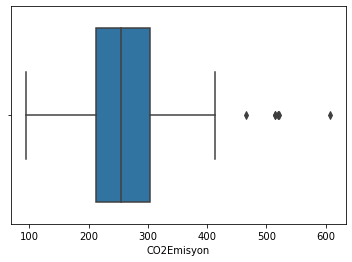

In [17]:
sns.boxplot(x =df_table);

In [18]:
Q1 = df_table.quantile(0.25)
Q3 = df_table.quantile(0.75)
IQR = Q3-Q1

In [19]:
alt_sinir = Q1- 1.5*IQR
ust_sinir = Q3 + 1.5*IQR

In [20]:
print(alt_sinir)
print(ust_sinir)

77.25
439.25


In [21]:
aykiri_tf = (df_table < alt_sinir) | (df_table > ust_sinir)
df_table[aykiri_tf]

123    522
124    608
548    520
549    520
550    515
551    515
825    465
Name: CO2Emisyon, dtype: int64

In [22]:
aykiri_alt = (df_table < alt_sinir) 
aykiri_ust= (df_table > ust_sinir)
df_table[aykiri_alt] = alt_sinir
df_table[aykiri_ust] = ust_sinir
df_table[120:125]

120    321.00
121    197.00
122    221.00
123    439.25
124    439.25
Name: CO2Emisyon, dtype: float64

In [23]:
df=df.drop(["CO2Emisyon"], axis = 1)
df["NewCO2Emisyon"]=df_table
df[120:125]

,Yil,Uretici,Model,Sinif,MotorHacim,Silindir,YakitTuketimi,NewCO2Emisyon
120,2021,BMW,X7 M50i,SUV: Standard,4.4,8,13.8,321.00
121,2021,BMW,Z4 sDrive30i,Two-seater,2.0,4,8.4,197.00
122,2021,BMW,Z4 M40i,Two-seater,3.0,6,9.5,221.00
123,2021,Bugatti,Chiron,Two-seater,8.0,16,22.2,439.25
124,2021,Bugatti,Chiron Pur Sport,Two-seater,8.0,16,26.1,439.25


Baskılama yöntemini kullanma sebebim diğer yöntemlere göre (silme, ortalama alma) daha performanslı çalışıp veri kaybını en aza getirceğini düşünmemdir.

In [24]:
df.isnull().sum()

Yil              0
Uretici          0
Model            0
Sinif            0
MotorHacim       0
Silindir         0
YakitTuketimi    0
NewCO2Emisyon    0
dtype: int64

## 4. Kategorik Değişken Özetleri

In [25]:
katdf = df.select_dtypes(include = ["category"])
katdf.head()

,Uretici,Sinif
0,Acura,Compact
1,Acura,Two-seater
2,Acura,SUV: Small
3,Acura,SUV: Small
4,Acura,Compact


In [26]:
df["Uretici"].value_counts()

Ford             87
Chevrolet        84
Mercedes-Benz    72
Porsche          63
GMC              61
BMW              54
Toyota           49
Audi             43
Jeep             36
Mazda            29
Hyundai          27
Lexus            27
Kia              25
Honda            23
Cadillac         22
Dodge            22
MINI             22
Nissan           22
Subaru           16
Ram              16
Volkswagen       16
Volvo            13
Maserati         11
Rolls-Royce      10
Lamborghini       9
Buick             9
Genesis           8
Bentley           8
Lincoln           7
Acura             6
Alfa Romeo        6
Infiniti          6
Chrysler          6
Aston Martin      6
Jaguar            6
Mitsubishi        5
Bugatti           2
FIAT              1
Name: Uretici, dtype: int64

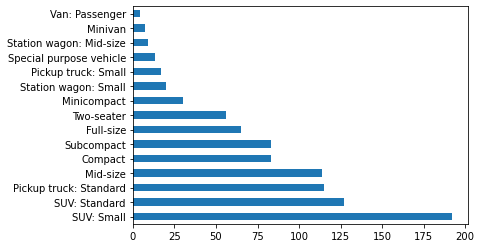

In [27]:
df["Sinif"].value_counts().plot.barh();

<AxesSubplot:xlabel='MotorHacim'>

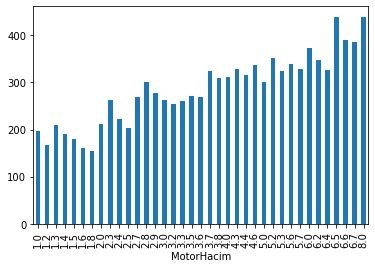

In [28]:
df[["NewCO2Emisyon","MotorHacim"]].groupby("MotorHacim")["NewCO2Emisyon"].mean().plot(kind="bar")

<AxesSubplot:xlabel='Silindir'>

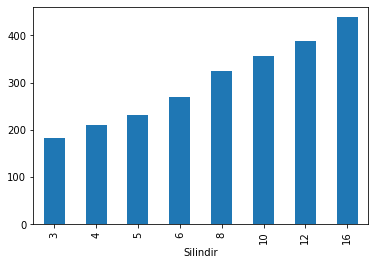

In [29]:
df[["NewCO2Emisyon","Silindir"]].groupby("Silindir")["NewCO2Emisyon"].mean().plot(kind="bar")

<AxesSubplot:xlabel='YakitTuketimi'>

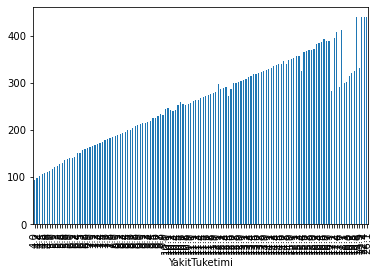

In [30]:
df[["NewCO2Emisyon","YakitTuketimi"]].groupby("YakitTuketimi")["NewCO2Emisyon"].mean().plot(kind="bar")

# Makine Öğrenmesi

## 1. Doğrusal Regresyon

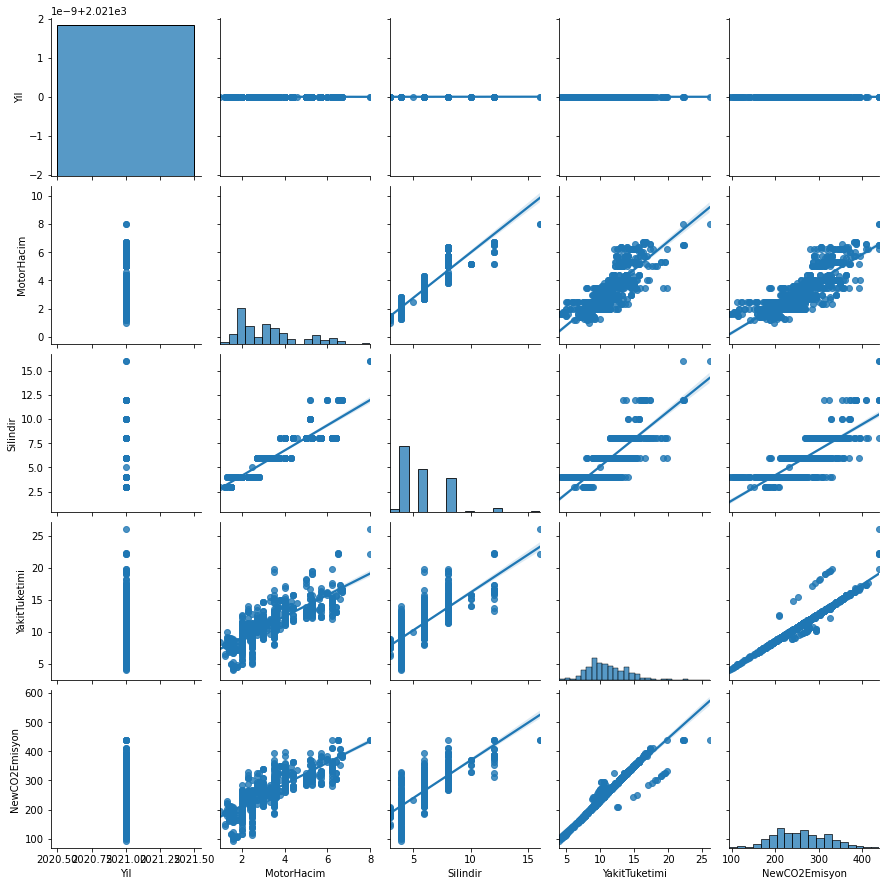

In [31]:
sns.pairplot(df, kind  ="reg")

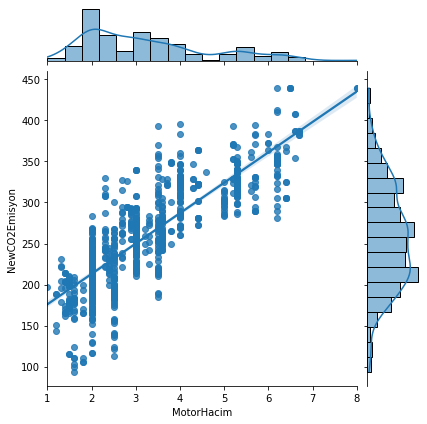

In [32]:
sns.jointplot(x = "MotorHacim", y = "NewCO2Emisyon", data = df, kind = "reg")

In [33]:
X = df[["MotorHacim"]]
y = df["NewCO2Emisyon"]
reg = LinearRegression()
model = reg.fit(X, y)
print(model.intercept_)
print(model.coef_)

138.81631515502562
[37.04098451]


In [34]:
model.score(X,y)

0.6854241337647258

In [35]:
model.predict(X)[0:10]

array([227.71467797, 268.45976093, 212.89828417, 212.89828417,
       212.89828417, 212.89828417, 212.89828417, 212.89828417,
       246.23517023, 212.89828417])

In [36]:
y[0:10]

0    199.0
1    256.0
2    232.0
3    242.0
4    230.0
5    231.0
6    205.0
7    217.0
8    271.0
9    218.0
Name: NewCO2Emisyon, dtype: float64

In [37]:
X[0:10]

,MotorHacim
0,2.4
1,3.5
2,2.0
3,2.0
4,2.0
5,2.0
6,2.0
7,2.0
8,2.9
9,2.0


In [38]:
(138.81)+(2*37.04098451)

212.89196902

In [39]:
model.predict([[2]])

array([212.89828417])

In [40]:
yeni_veri = [[1.8],[2],[2.4]]
model.predict(yeni_veri)

array([205.49008727, 212.89828417, 227.71467797])

In [41]:
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.formula.api as smf

lm = smf.ols("NewCO2Emisyon ~ MotorHacim", df)
model = lm.fit()
model.summary()
mse = mean_squared_error(y, model.fittedvalues)
#gerçek değerler ile tahmin edilen değerler arasındaki farkların karelerinin ortalaması
mse

1212.7364725198129

In [42]:
rmse = np.sqrt(mse)
rmse

34.82436607491675

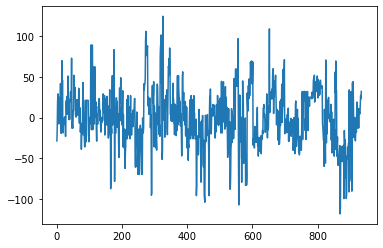

In [43]:
plt.plot(model.resid[:1000])

## 1.2. Çoklu Doğrusal Regresyon

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Yil            935 non-null    int64   
 1   Uretici        935 non-null    category
 2   Model          935 non-null    object  
 3   Sinif          935 non-null    category
 4   MotorHacim     935 non-null    float64 
 5   Silindir       935 non-null    int64   
 6   YakitTuketimi  935 non-null    float64 
 7   NewCO2Emisyon  935 non-null    float64 
dtypes: category(2), float64(3), int64(2), object(1)
memory usage: 47.8+ KB


In [45]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
X = df.drop(df.columns[[0,1,2,3,7]], axis = 1)
y = df["NewCO2Emisyon"]
#randomstate her üretme işleminde farklı değerler çıkmasını istemedigimizden rastgele bir değer veriyoruz
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

training = df.copy()
training.shape

(748, 3)
(748,)
(187, 3)
(187,)


(935, 8)

In [46]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
model = lm.fit(X_train, y_train)
#sabit katsayı
print(model.intercept_)
#bağımsız deşişken katsayıları 
print(model.coef_)

34.888662650912465
[ 5.00400369  0.71933983 18.35837014]


In [47]:
yeni_veri = [[2],[4],[14]]
yeni_veri = pd.DataFrame(yeni_veri).T
model.predict(yeni_veri)

array([304.79121131])

In [48]:
from sklearn.metrics import mean_squared_error
#eğitim hatası
rmse = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
rmse

16.00924186821895

In [49]:
#test hatası
rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
rmse

15.439147298599496

Model Tuning / Model Doğrulama

In [50]:
df.head()

,Yil,Uretici,Model,Sinif,MotorHacim,Silindir,YakitTuketimi,NewCO2Emisyon
0,2021,Acura,ILX,Compact,2.4,4,8.6,199.0
1,2021,Acura,NSX,Two-seater,3.5,6,11.0,256.0
2,2021,Acura,RDX SH-AWD,SUV: Small,2.0,4,9.9,232.0
3,2021,Acura,RDX SH-AWD A-SPEC,SUV: Small,2.0,4,10.3,242.0
4,2021,Acura,TLX SH-AWD,Compact,2.0,4,9.8,230.0


In [51]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
X = df.drop(df.columns[[0,1,2,3,7]], axis = 1)
y = df["NewCO2Emisyon"]
#randomstate her üretme işleminde farklı değerler çıkmasını istemedigimizden rastgele bir değer veriyoruz
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

training = df.copy()
training.shape

(748, 3)
(748,)
(187, 3)
(187,)


(935, 8)

In [52]:
rmseTrain=np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
print(rmseTrain)
rmseTest=np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
print(rmseTest)
model.score(X_train, y_train)

16.00924186821895
15.439147298599496


0.9333876124699255

In [53]:
#eğitim verileri için çapraz doğrulama ile elde edilmiş ortalama r2 skoru
cross_val_score(model, X_train, y_train, cv = 10, scoring = "r2").mean()

0.9297602332528869

In [54]:
#neg_mean_squared_error'da sonuc negatif olacağı için üstte (-) ile çarpıyoruz 
rmseTrain=np.sqrt(-cross_val_score(model, 
                X_train, 
                y_train, 
                cv = 10, 
                scoring = "neg_mean_squared_error")).mean()
print(rmseTrain)
rmseTest=np.sqrt(-cross_val_score(model, 
                X_test, 
                y_test, 
                cv = 10, 
                scoring = "neg_mean_squared_error")).mean()
print(rmseTest)

16.004734282779587
13.711255458211218


## 2. Doğrusal Olmayan Regresyon

### 2.1. K En Yakın Komşu (KNN)

In [55]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
X = df.drop(df.columns[[0,1,2,3,7]], axis = 1)
y = df["NewCO2Emisyon"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
training = df.copy()

In [56]:
knn_model = KNeighborsRegressor().fit(X_train, y_train)

In [57]:
y_pred = knn_model.predict(X_test)
print("test hatası:" , np.sqrt(mean_squared_error(y_test, y_pred)))
RMSE = [] 
#cross validation yapmadan hatalara bir bakalim
for k in range(10):
    k = k+1
    knn_model = KNeighborsRegressor(n_neighbors = k).fit(X_train, y_train)
    y_pred = knn_model.predict(X_train) 
    rmse = np.sqrt(mean_squared_error(y_train,y_pred)) 
    RMSE.append(rmse) 
    print("k =" , k , "için RMSE değeri: ", rmse)

test hatası: 11.540630565361402
k = 1 için RMSE değeri:  4.119990582098012
k = 2 için RMSE değeri:  6.4752508777729885
k = 3 için RMSE değeri:  7.138967138110195
k = 4 için RMSE değeri:  8.253411965205887
k = 5 için RMSE değeri:  9.006110225730243
k = 6 için RMSE değeri:  9.59849299216895
k = 7 için RMSE değeri:  9.770424747359053
k = 8 için RMSE değeri:  10.112139960290198
k = 9 için RMSE değeri:  10.617915564821951
k = 10 için RMSE değeri:  10.933928548754674


In [58]:
#GridSearchCV ile optimum k sayisinin belirlenmesi
knn_params = {'n_neighbors': np.arange(1,30,1)}
knn = KNeighborsRegressor()
knn_cv_model = GridSearchCV(knn, knn_params, cv = 10)
knn_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})

In [59]:
knn_cv_model.best_params_["n_neighbors"]

2

In [60]:
RMSE = [] 
RMSE_CV = []
for k in range(10):
    k = k+1
    knn_model = KNeighborsRegressor(n_neighbors = k).fit(X_train, y_train)
    y_pred = knn_model.predict(X_train) 
    rmse = np.sqrt(mean_squared_error(y_train,y_pred)) 
    rmse_cv = np.sqrt(-1*cross_val_score(knn_model, X_train, y_train, cv=10, 
                                         scoring = "neg_mean_squared_error").mean())
    #cross validation olmadan hatalar
    RMSE.append(rmse) 
    #cross validation kullanilarak alindan hatalar
    RMSE_CV.append(rmse_cv)
    print("k =" , k , "için RMSE değeri: ", rmse, "RMSE_CV değeri: ", rmse_cv )

k = 1 için RMSE değeri:  4.119990582098012 RMSE_CV değeri:  11.953831320940454
k = 2 için RMSE değeri:  6.4752508777729885 RMSE_CV değeri:  10.594642630348073
k = 3 için RMSE değeri:  7.138967138110195 RMSE_CV değeri:  11.06919494661434
k = 4 için RMSE değeri:  8.253411965205887 RMSE_CV değeri:  11.605400553629595
k = 5 için RMSE değeri:  9.006110225730243 RMSE_CV değeri:  11.565269301842687
k = 6 için RMSE değeri:  9.59849299216895 RMSE_CV değeri:  11.494180746582137
k = 7 için RMSE değeri:  9.770424747359053 RMSE_CV değeri:  12.000564549693228
k = 8 için RMSE değeri:  10.112139960290198 RMSE_CV değeri:  12.167158834773264
k = 9 için RMSE değeri:  10.617915564821951 RMSE_CV değeri:  12.163186373966388
k = 10 için RMSE değeri:  10.933928548754674 RMSE_CV değeri:  12.272732440017814


In [61]:
#k=3 için train degil test setini denediğimizde
knn_tuned = KNeighborsRegressor(n_neighbors =3)
knn_tuned.fit(X_train, y_train)
np.sqrt(mean_squared_error(y_test, knn_tuned.predict(X_test)))

10.586392204383571

In [62]:
knn_tuned = KNeighborsRegressor(n_neighbors = knn_cv_model.best_params_["n_neighbors"])
knn_tuned.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=2)

In [63]:
np.sqrt(mean_squared_error(y_test, knn_tuned.predict(X_test)))

11.300385743359293

### 2.3. Bagged Trees Regresyon

In [64]:
X = df.drop(df.columns[[0,1,2,3,7]], axis = 1)
y = df["NewCO2Emisyon"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
training = df.copy()

In [65]:
#bootstrap_features default degeri false, bootstrap orneklerini gozlemlemek icin true verdik
bag_model = BaggingRegressor(bootstrap_features = True)
bag_model.fit(X_train, y_train)

BaggingRegressor(bootstrap_features=True)

In [66]:
#tahminci sayisi
bag_model.n_estimators

10

In [67]:
#10 adet agac
bag_model.estimators_

[DecisionTreeRegressor(random_state=1641159228),
 DecisionTreeRegressor(random_state=1821724054),
 DecisionTreeRegressor(random_state=818595832),
 DecisionTreeRegressor(random_state=641351797),
 DecisionTreeRegressor(random_state=1774888500),
 DecisionTreeRegressor(random_state=1535094231),
 DecisionTreeRegressor(random_state=534219232),
 DecisionTreeRegressor(random_state=710270039),
 DecisionTreeRegressor(random_state=1281480716),
 DecisionTreeRegressor(random_state=1713616593)]

In [68]:
#her bir agacin ornekleri
bag_model.estimators_samples_

[array([670, 572, 242, 521, 498, 625, 186, 670, 278,  63, 264,  96, 487,
        205, 650, 372,  11, 690, 287, 156, 466, 573, 382, 256, 112, 336,
        407, 435, 639, 578, 614, 156, 584,  36,  98, 652, 480, 149, 593,
        577, 494, 153, 345, 626, 281, 103, 227, 350, 551, 635, 159, 167,
        615, 513, 356, 136,   7, 599,  77, 345, 669, 414, 222, 619, 493,
         39, 667, 698, 479, 534, 127, 160, 419, 670, 664, 473, 581,  91,
         73, 191, 628, 486, 527, 109, 500, 485, 403, 505, 634, 516, 308,
         76, 329, 579, 658, 669,  13,  11, 664, 144, 578, 644, 693, 458,
        380,   2, 486, 683, 693, 612, 369, 548, 171, 517, 190, 695,  63,
        665, 393, 541, 441, 511,  29, 121,  87, 160, 138, 127, 578,  17,
        184, 351, 383,  73, 329, 135, 206, 559, 207, 514, 586,  38, 616,
        580, 353, 532, 564, 584,  36, 381, 105, 367,  70, 444, 128, 198,
        503, 429, 388, 525, 180, 125, 668, 426, 576, 275, 257, 338, 189,
        530,  83, 260,  79, 673, 415, 214, 108, 141

In [69]:
#her agacin bagimsiz degiskenleri
bag_model.estimators_features_

[array([0, 0, 0]),
 array([2, 0, 2]),
 array([0, 0, 0]),
 array([1, 1, 0]),
 array([0, 0, 0]),
 array([0, 2, 0]),
 array([0, 1, 2]),
 array([1, 0, 0]),
 array([0, 1, 2]),
 array([1, 1, 2])]

### Tahmin

In [70]:
y_pred = bag_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

17.19857364380153

In [71]:
iki_y_pred = bag_model.estimators_[1].fit(X_train, y_train).predict(X_test)

In [72]:
np.sqrt(mean_squared_error(y_test, iki_y_pred))

13.231468115928026

In [73]:
yedi_y_pred = bag_model.estimators_[6].fit(X_train, y_train).predict(X_test)

In [74]:
np.sqrt(mean_squared_error(y_test, yedi_y_pred))

12.111137621451006

### Model Tuning

In [75]:
bag_model = BaggingRegressor(bootstrap_features = True)
bag_model.fit(X_train, y_train)

BaggingRegressor(bootstrap_features=True)

In [76]:
bag_params = {"n_estimators": range(2,20)}

In [77]:
bag_cv_model = GridSearchCV(bag_model, bag_params, cv = 10)

In [78]:
bag_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=BaggingRegressor(bootstrap_features=True),
             param_grid={'n_estimators': range(2, 20)})

In [79]:
bag_cv_model.best_params_

{'n_estimators': 16}

In [80]:
bag_tuned = BaggingRegressor( n_estimators = 11, random_state = 45)

In [81]:
bag_tuned.fit(X_train, y_train)

BaggingRegressor(n_estimators=11, random_state=45)

In [82]:
y_pred = bag_tuned.predict(X_test)

In [83]:
np.sqrt(mean_squared_error(y_test, y_pred))

11.484277269618588

### 2.4. Random Forests

In [84]:
X = df.drop(df.columns[[0,1,2,3,7]], axis = 1)
y = df["NewCO2Emisyon"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
training = df.copy()

In [85]:
rf_model = RandomForestRegressor(random_state = 42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### Tahmin

In [86]:
rf_model.predict(X_test)[0:5]

array([308.655    , 224.4647197, 306.04     , 439.25     , 205.5136811])

In [87]:
y_pred = rf_model.predict(X_test)

In [88]:
np.sqrt(mean_squared_error(y_test, y_pred))

11.832323705885358

### Model Tuning

In [89]:
rf_params = {'max_depth': list(range(1,10)),
            'max_features': [3,5,10,15],
            'n_estimators' : [100, 200, 500, 1000, 2000]}
rf_model = RandomForestRegressor(random_state = 42)
rf_cv_model = GridSearchCV(rf_model, 
                           rf_params, 
                           cv = 10, 
                            n_jobs = -1)


In [90]:
rf_cv_model.fit(X_train, y_train)
rf_cv_model.best_params_

{'max_depth': 8, 'max_features': 3, 'n_estimators': 2000}

In [91]:
rf_tuned = RandomForestRegressor(max_depth  = 8, 
                                 max_features = 3, 
                                 n_estimators =2000)

In [92]:
rf_tuned.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, max_features=3, n_estimators=2000)

In [93]:
y_pred = rf_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

11.807432071971633

In [94]:
#degiskenlerin onem duzeyine bir bakalim.
Importance = pd.DataFrame({"Importance": rf_tuned.feature_importances_*100},
                         index = X_train.columns)

Text(0.5, 0, 'Değişken Önem Düzeyleri')

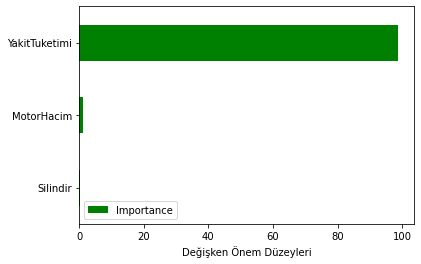

In [95]:
Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "g")

plt.xlabel("Değişken Önem Düzeyleri")

### 2.5. Gradient Boosting Machines (GBM)

In [96]:
X = df.drop(df.columns[[0,1,2,3,7]], axis = 1)
y = df["NewCO2Emisyon"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
training = df.copy()

In [97]:
gbm_model = GradientBoostingRegressor()
gbm_model.fit(X_train, y_train)

GradientBoostingRegressor()

### Tahmin

In [98]:
y_pred = gbm_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

8.67089690720073

### Model Tuning

In [99]:
gbm_params = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [3, 5, 8,50,100],
    'n_estimators': [200, 500, 1000, 2000],
    'subsample': [1,0.5,0.75],
}

In [100]:
#algoritmanın calisma zamanina da bir bakalim
t1 =  datetime.now()
gbm = GradientBoostingRegressor()
gbm_cv_model = GridSearchCV(gbm, gbm_params, cv = 10, n_jobs = -1, verbose = 2)
gbm_cv_model.fit(X_train, y_train)

t2 =  datetime.now()
print(t2-t1)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
0:05:56.931741


In [101]:
gbm_cv_model.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.5}

In [102]:
gbm_tuned = GradientBoostingRegressor(learning_rate = 0.1,  
                                      max_depth = 3, 
                                      n_estimators = 200, 
                                      subsample = 0.5)

gbm_tuned = gbm_tuned.fit(X_train,y_train)

In [103]:
y_pred = gbm_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

8.625314999248404

In [104]:
Importance = pd.DataFrame({"Importance": gbm_tuned.feature_importances_*100},
                         index = X_train.columns)

Text(0.5, 0, 'Değişken Önem Düzeyleri')

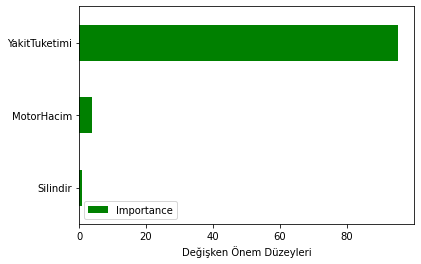

In [105]:
Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "g")

plt.xlabel("Değişken Önem Düzeyleri")

### 2.6. XGBoost (eXtreme Gradient Boosting)

In [106]:
X = df.drop(df.columns[[0,1,2,3,7]], axis = 1)
y = df["NewCO2Emisyon"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
training = df.copy()

In [107]:
DM_train = xgb.DMatrix(data = X_train, label = y_train)
DM_test = xgb.DMatrix(data = X_test, label = y_test)

In [108]:
xgb_model = XGBRegressor().fit(X_train, y_train)

Tahmin

In [109]:
y_pred = xgb_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

8.49266260017561

Model Tuning

In [110]:
xgb_grid = {
     'colsample_bytree': [0.4, 0.5,0.6,0.9,1], 
     'n_estimators':[100, 200, 500, 1000],
     'max_depth': [2,3,4,5,6],
     'learning_rate': [0.1, 0.01, 0.5]
}


In [111]:
t1 =  datetime.now()

xgb = XGBRegressor()
xgb_cv = GridSearchCV(xgb, 
                      param_grid = xgb_grid, 
                      cv = 10, 
                      n_jobs = -1,
                      verbose = 2)

xgb_cv.fit(X_train, y_train)

t2 =  datetime.now()
print(t2-t1)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits
0:01:30.345459


In [112]:
xgb_cv.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100}

In [113]:
xgb_tuned = XGBRegressor(colsample_bytree = 1, 
                         learning_rate = 0.1, 
                         max_depth = 3, 
                         n_estimators = 100) 

xgb_tuned = xgb_tuned.fit(X_train,y_train)

In [114]:
y_pred = xgb_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

9.108771440554069

### 2.7. Light GBM

In [115]:
X = df.drop(df.columns[[0,1,2,3,7]], axis = 1)
y = df["NewCO2Emisyon"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
training = df.copy()

In [116]:
lgbm = LGBMRegressor()
lgbm_model = lgbm.fit(X_train, y_train)

### Tahmin

In [117]:
y_pred = lgbm_model.predict(X_test, 
                            num_iteration = lgbm_model.best_iteration_)

In [118]:
np.sqrt(mean_squared_error(y_test, y_pred))

11.268910346784601

### Model Tuning

In [119]:
lgbm_grid = {
    'colsample_bytree': [0.4, 0.5,0.6,0.9,1],
    'learning_rate': [0.01, 0.1, 0.5,1],
    'n_estimators': [20, 40, 100, 200, 500,1000],
    'max_depth': [1,2,3,4,5,6,7,8] }

lgbm = LGBMRegressor()
lgbm_cv_model = GridSearchCV(lgbm, lgbm_grid, cv=10, n_jobs = -1, verbose = 2)

In [120]:
t1 =  datetime.now()
lgbm_cv_model.fit(X_train, y_train)
t2 =  datetime.now()
print(t2-t1)

Fitting 10 folds for each of 960 candidates, totalling 9600 fits
0:02:24.539226


In [121]:
lgbm_cv_model.best_params_

{'colsample_bytree': 0.9,
 'learning_rate': 0.5,
 'max_depth': 3,
 'n_estimators': 1000}

In [122]:
lgbm_tuned = LGBMRegressor(learning_rate = 0.5, 
                           max_depth = 3, 
                           n_estimators = 1000,
                          colsample_bytree = 0.9)

lgbm_tuned = lgbm_tuned.fit(X_train,y_train)

In [123]:
y_pred = lgbm_tuned.predict(X_test)

In [124]:
np.sqrt(mean_squared_error(y_test, y_pred))

10.021568473521802

### 2.8. CatBoost


In [125]:
X = df.drop(df.columns[[0,1,2,3,7]], axis = 1)
y = df["NewCO2Emisyon"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
training = df.copy()

In [126]:
catb = CatBoostRegressor()
catb_model = catb.fit(X_train, y_train)

Learning rate set to 0.038708
0:	learn: 60.4772236	total: 131ms	remaining: 2m 10s
1:	learn: 58.5727618	total: 132ms	remaining: 1m 6s
2:	learn: 56.7654948	total: 134ms	remaining: 44.4s
3:	learn: 54.9200770	total: 135ms	remaining: 33.6s
4:	learn: 53.2310693	total: 136ms	remaining: 27.1s
5:	learn: 51.6238358	total: 137ms	remaining: 22.7s
6:	learn: 50.0175301	total: 139ms	remaining: 19.6s
7:	learn: 48.4319095	total: 140ms	remaining: 17.3s
8:	learn: 46.9385087	total: 141ms	remaining: 15.5s
9:	learn: 45.4576812	total: 142ms	remaining: 14.1s
10:	learn: 44.0869731	total: 144ms	remaining: 12.9s
11:	learn: 42.7585442	total: 145ms	remaining: 11.9s
12:	learn: 41.4404001	total: 146ms	remaining: 11.1s
13:	learn: 40.1803744	total: 148ms	remaining: 10.4s
14:	learn: 39.0200011	total: 149ms	remaining: 9.77s
15:	learn: 37.9045077	total: 150ms	remaining: 9.23s
16:	learn: 36.8285603	total: 151ms	remaining: 8.75s
17:	learn: 35.7823368	total: 153ms	remaining: 8.32s
18:	learn: 34.7781936	total: 154ms	remainin

174:	learn: 7.1482653	total: 338ms	remaining: 1.59s
175:	learn: 7.1243327	total: 339ms	remaining: 1.59s
176:	learn: 7.1046250	total: 340ms	remaining: 1.58s
177:	learn: 7.0785319	total: 342ms	remaining: 1.58s
178:	learn: 7.0608076	total: 343ms	remaining: 1.57s
179:	learn: 7.0439387	total: 344ms	remaining: 1.57s
180:	learn: 7.0310376	total: 345ms	remaining: 1.56s
181:	learn: 7.0153453	total: 347ms	remaining: 1.56s
182:	learn: 6.9999442	total: 348ms	remaining: 1.55s
183:	learn: 6.9874816	total: 349ms	remaining: 1.55s
184:	learn: 6.9665820	total: 350ms	remaining: 1.54s
185:	learn: 6.9366767	total: 352ms	remaining: 1.54s
186:	learn: 6.9160380	total: 353ms	remaining: 1.53s
187:	learn: 6.8946174	total: 354ms	remaining: 1.53s
188:	learn: 6.8819135	total: 355ms	remaining: 1.52s
189:	learn: 6.8686784	total: 357ms	remaining: 1.52s
190:	learn: 6.8661284	total: 358ms	remaining: 1.51s
191:	learn: 6.8527597	total: 359ms	remaining: 1.51s
192:	learn: 6.8398959	total: 360ms	remaining: 1.5s
193:	learn: 6

458:	learn: 4.8887204	total: 671ms	remaining: 791ms
459:	learn: 4.8876354	total: 673ms	remaining: 790ms
460:	learn: 4.8864527	total: 674ms	remaining: 788ms
461:	learn: 4.8819215	total: 675ms	remaining: 786ms
462:	learn: 4.8809545	total: 676ms	remaining: 784ms
463:	learn: 4.8805503	total: 677ms	remaining: 783ms
464:	learn: 4.8757920	total: 679ms	remaining: 781ms
465:	learn: 4.8751362	total: 680ms	remaining: 779ms
466:	learn: 4.8710371	total: 681ms	remaining: 777ms
467:	learn: 4.8697068	total: 682ms	remaining: 775ms
468:	learn: 4.8654262	total: 683ms	remaining: 773ms
469:	learn: 4.8644637	total: 684ms	remaining: 771ms
470:	learn: 4.8550872	total: 685ms	remaining: 770ms
471:	learn: 4.8537313	total: 686ms	remaining: 768ms
472:	learn: 4.8492793	total: 688ms	remaining: 766ms
473:	learn: 4.8454304	total: 689ms	remaining: 764ms
474:	learn: 4.8442818	total: 690ms	remaining: 763ms
475:	learn: 4.8343719	total: 691ms	remaining: 761ms
476:	learn: 4.8289146	total: 693ms	remaining: 759ms
477:	learn: 

739:	learn: 4.0044424	total: 1s	remaining: 353ms
740:	learn: 4.0041360	total: 1.01s	remaining: 352ms
741:	learn: 3.9996348	total: 1.01s	remaining: 351ms
742:	learn: 3.9988660	total: 1.01s	remaining: 349ms
743:	learn: 3.9986587	total: 1.01s	remaining: 348ms
744:	learn: 3.9982352	total: 1.01s	remaining: 346ms
745:	learn: 3.9960429	total: 1.01s	remaining: 345ms
746:	learn: 3.9956366	total: 1.01s	remaining: 344ms
747:	learn: 3.9941952	total: 1.01s	remaining: 342ms
748:	learn: 3.9926152	total: 1.02s	remaining: 341ms
749:	learn: 3.9915497	total: 1.02s	remaining: 339ms
750:	learn: 3.9868692	total: 1.02s	remaining: 338ms
751:	learn: 3.9864448	total: 1.02s	remaining: 336ms
752:	learn: 3.9840146	total: 1.02s	remaining: 335ms
753:	learn: 3.9834211	total: 1.02s	remaining: 334ms
754:	learn: 3.9826256	total: 1.02s	remaining: 332ms
755:	learn: 3.9822073	total: 1.02s	remaining: 331ms
756:	learn: 3.9811519	total: 1.02s	remaining: 329ms
757:	learn: 3.9770162	total: 1.03s	remaining: 328ms
758:	learn: 3.9

### Tahmin

In [127]:
y_pred = catb_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

8.51960525522995

### Model Tuning

In [128]:
catb_grid = {
    'iterations': [200,500,1000,2000],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'depth': [3,4,5,6,7,8] }

In [129]:
catb = CatBoostRegressor()
catb_cv_model = GridSearchCV(catb, catb_grid, cv=5, n_jobs = -1, verbose = 2)

In [130]:
t1 =  datetime.now()
catb_cv_model.fit(X_train, y_train)
t2 =  datetime.now()
print(t2-t1)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
0:	learn: 57.2426338	total: 1.75ms	remaining: 875ms
1:	learn: 52.7410055	total: 3.54ms	remaining: 881ms
2:	learn: 48.4677917	total: 5.09ms	remaining: 844ms
3:	learn: 44.6714799	total: 6.79ms	remaining: 842ms
4:	learn: 41.3093612	total: 8.38ms	remaining: 830ms
5:	learn: 38.2561461	total: 9.45ms	remaining: 778ms
6:	learn: 35.2281129	total: 11ms	remaining: 776ms
7:	learn: 32.5182324	total: 12.5ms	remaining: 771ms
8:	learn: 30.2313917	total: 14.1ms	remaining: 768ms
9:	learn: 28.1736864	total: 15.6ms	remaining: 765ms
10:	learn: 26.1573522	total: 17.2ms	remaining: 766ms
11:	learn: 24.4132767	total: 18.8ms	remaining: 763ms
12:	learn: 22.9225734	total: 20.3ms	remaining: 762ms
13:	learn: 21.5807779	total: 21.9ms	remaining: 760ms
14:	learn: 20.4002656	total: 23.5ms	remaining: 760ms
15:	learn: 19.2554082	total: 25ms	remaining: 756ms
16:	learn: 18.1236764	total: 26.6ms	remaining: 755ms
17:	learn: 17.1951094	total: 28.1ms	remaining: 752m

214:	learn: 4.1985475	total: 336ms	remaining: 445ms
215:	learn: 4.1885102	total: 338ms	remaining: 444ms
216:	learn: 4.1815483	total: 339ms	remaining: 442ms
217:	learn: 4.1797640	total: 341ms	remaining: 441ms
218:	learn: 4.1663462	total: 342ms	remaining: 439ms
219:	learn: 4.1609561	total: 344ms	remaining: 438ms
220:	learn: 4.1541765	total: 345ms	remaining: 436ms
221:	learn: 4.1479604	total: 347ms	remaining: 435ms
222:	learn: 4.1433265	total: 349ms	remaining: 433ms
223:	learn: 4.1386123	total: 351ms	remaining: 432ms
224:	learn: 4.1274714	total: 352ms	remaining: 431ms
225:	learn: 4.1259464	total: 354ms	remaining: 430ms
226:	learn: 4.1228907	total: 356ms	remaining: 428ms
227:	learn: 4.1186529	total: 358ms	remaining: 427ms
228:	learn: 4.1053783	total: 359ms	remaining: 425ms
229:	learn: 4.0961951	total: 361ms	remaining: 424ms
230:	learn: 4.0949882	total: 363ms	remaining: 423ms
231:	learn: 4.0888344	total: 364ms	remaining: 421ms
232:	learn: 4.0870418	total: 366ms	remaining: 419ms
233:	learn: 

428:	learn: 3.5203863	total: 678ms	remaining: 112ms
429:	learn: 3.5196621	total: 680ms	remaining: 111ms
430:	learn: 3.5182547	total: 682ms	remaining: 109ms
431:	learn: 3.5179611	total: 683ms	remaining: 108ms
432:	learn: 3.5177111	total: 685ms	remaining: 106ms
433:	learn: 3.5151688	total: 687ms	remaining: 104ms
434:	learn: 3.5141042	total: 689ms	remaining: 103ms
435:	learn: 3.5135830	total: 690ms	remaining: 101ms
436:	learn: 3.5120578	total: 692ms	remaining: 99.8ms
437:	learn: 3.5118077	total: 693ms	remaining: 98.1ms
438:	learn: 3.5116265	total: 695ms	remaining: 96.5ms
439:	learn: 3.5111822	total: 696ms	remaining: 94.9ms
440:	learn: 3.5088365	total: 698ms	remaining: 93.3ms
441:	learn: 3.5078826	total: 699ms	remaining: 91.8ms
442:	learn: 3.5076055	total: 701ms	remaining: 90.2ms
443:	learn: 3.5073601	total: 702ms	remaining: 88.6ms
444:	learn: 3.5064010	total: 704ms	remaining: 87ms
445:	learn: 3.5061880	total: 705ms	remaining: 85.4ms
446:	learn: 3.5050925	total: 707ms	remaining: 83.8ms
447

In [131]:
catb_cv_model.best_params_

{'depth': 7, 'iterations': 500, 'learning_rate': 0.1}

In [132]:
catb_tuned = CatBoostRegressor(iterations = 500, 
                               learning_rate = 0.1, 
                               depth = 7)

catb_tuned = catb_tuned.fit(X_train,y_train)

0:	learn: 57.2426338	total: 1.87ms	remaining: 934ms
1:	learn: 52.7410055	total: 3.68ms	remaining: 916ms
2:	learn: 48.4677917	total: 5.37ms	remaining: 889ms
3:	learn: 44.6714799	total: 7.04ms	remaining: 873ms
4:	learn: 41.3093612	total: 9.14ms	remaining: 905ms
5:	learn: 38.2561461	total: 10.5ms	remaining: 864ms
6:	learn: 35.2281129	total: 12.3ms	remaining: 868ms
7:	learn: 32.5182324	total: 14.2ms	remaining: 871ms
8:	learn: 30.2313917	total: 15.9ms	remaining: 870ms
9:	learn: 28.1736864	total: 17.8ms	remaining: 872ms
10:	learn: 26.1573522	total: 19.5ms	remaining: 869ms
11:	learn: 24.4132767	total: 21.3ms	remaining: 866ms
12:	learn: 22.9225734	total: 22.9ms	remaining: 860ms
13:	learn: 21.5807779	total: 24.7ms	remaining: 857ms
14:	learn: 20.4002656	total: 26.4ms	remaining: 855ms
15:	learn: 19.2554082	total: 28.3ms	remaining: 856ms
16:	learn: 18.1236764	total: 30.1ms	remaining: 855ms
17:	learn: 17.1951094	total: 31.8ms	remaining: 853ms
18:	learn: 16.4473785	total: 33.6ms	remaining: 851ms
19:

185:	learn: 4.4869406	total: 333ms	remaining: 562ms
186:	learn: 4.4850984	total: 335ms	remaining: 560ms
187:	learn: 4.4679576	total: 337ms	remaining: 558ms
188:	learn: 4.4655979	total: 338ms	remaining: 557ms
189:	learn: 4.4545852	total: 340ms	remaining: 555ms
190:	learn: 4.4533385	total: 342ms	remaining: 554ms
191:	learn: 4.4384837	total: 344ms	remaining: 552ms
192:	learn: 4.4283191	total: 347ms	remaining: 551ms
193:	learn: 4.4270312	total: 349ms	remaining: 550ms
194:	learn: 4.4185658	total: 351ms	remaining: 548ms
195:	learn: 4.3929627	total: 353ms	remaining: 547ms
196:	learn: 4.3859924	total: 354ms	remaining: 545ms
197:	learn: 4.3704650	total: 356ms	remaining: 543ms
198:	learn: 4.3544273	total: 358ms	remaining: 541ms
199:	learn: 4.3476705	total: 360ms	remaining: 539ms
200:	learn: 4.3450907	total: 361ms	remaining: 538ms
201:	learn: 4.3230529	total: 363ms	remaining: 536ms
202:	learn: 4.3210953	total: 365ms	remaining: 534ms
203:	learn: 4.3078018	total: 367ms	remaining: 532ms
204:	learn: 

394:	learn: 3.5655183	total: 673ms	remaining: 179ms
395:	learn: 3.5638593	total: 675ms	remaining: 177ms
396:	learn: 3.5632532	total: 677ms	remaining: 176ms
397:	learn: 3.5628552	total: 678ms	remaining: 174ms
398:	learn: 3.5616339	total: 680ms	remaining: 172ms
399:	learn: 3.5610839	total: 682ms	remaining: 170ms
400:	learn: 3.5606933	total: 683ms	remaining: 169ms
401:	learn: 3.5602720	total: 685ms	remaining: 167ms
402:	learn: 3.5589183	total: 686ms	remaining: 165ms
403:	learn: 3.5576343	total: 688ms	remaining: 163ms
404:	learn: 3.5552756	total: 690ms	remaining: 162ms
405:	learn: 3.5543211	total: 691ms	remaining: 160ms
406:	learn: 3.5528702	total: 693ms	remaining: 158ms
407:	learn: 3.5515431	total: 694ms	remaining: 157ms
408:	learn: 3.5499500	total: 696ms	remaining: 155ms
409:	learn: 3.5479277	total: 698ms	remaining: 153ms
410:	learn: 3.5434110	total: 699ms	remaining: 151ms
411:	learn: 3.5428385	total: 701ms	remaining: 150ms
412:	learn: 3.5422956	total: 703ms	remaining: 148ms
413:	learn: 

In [133]:
y_pred = catb_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

7.934338783981605

In [138]:
catb_tuned.predict([[1.4,6,10]])

array([238.52527672])

In [139]:
catb_tuned.predict([[1.4,6,15]])

array([281.39836509])

In [140]:
catb_tuned.predict([[1.4,3,10]])

array([236.94340635])

In [136]:
catb_tuned.predict([[2,6,10]])

array([236.58130151])

In [137]:
catb_tuned.predict([[3,6,10]])

array([260.29984932])

    Veri setimiz için en uygun model CastBoost'dur. En düşük hata değerini döndürmüştür. 1.4 motor gücüne sahip aracımız 6 silindir ve 10 litre yakıt tüketimine sahipken 238.52 CO2 salımına sahipken sadece motor hacmini 2 olarak değiştirdiğimizde 236.10 CO2 salınımı yapıyor. Yakıt tüketimini ise 15'e çıkardığımızda 238.52'den 281.39'e çıkıyor. Silindir değerini 6'dan 3'e düşürdüğümüzde 238.52'den 236.94'e düşüyor. CO2 salınımı tahminlerimizin ışığında değeri en çok etkileyen parametremizin yakıt tüketimi olduğunu görüyoruz. 